<a href="https://colab.research.google.com/github/PhillipMas/PhillipMas/blob/main/VaR_Rolling_Window_wth_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!!pip install arch

['Collecting arch',
 '  Downloading arch-7.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)',
 'Requirement already satisfied: numpy>=1.22.3 in /usr/local/lib/python3.10/dist-packages (from arch) (1.26.4)',
 'Requirement already satisfied: scipy>=1.8 in /usr/local/lib/python3.10/dist-packages (from arch) (1.13.1)',
 'Requirement already satisfied: pandas>=1.4 in /usr/local/lib/python3.10/dist-packages (from arch) (2.1.4)',
 'Requirement already satisfied: statsmodels>=0.12 in /usr/local/lib/python3.10/dist-packages (from arch) (0.14.2)',
 'Requirement already satisfied: python-dateutil>=2.8.2 in /usr/local/lib/python3.10/dist-packages (from pandas>=1.4->arch) (2.8.2)',
 'Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.10/dist-packages (from pandas>=1.4->arch) (2024.1)',
 'Requirement already satisfied: tzdata>=2022.1 in /usr/local/lib/python3.10/dist-packages (from pandas>=1.4->arch) (2024.1)',
 'Requirement already satisfied: patsy>

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm as norms
from scipy.stats import chi2 #

In [3]:
# Function to fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']

# Define parameters
ticker = '^J203.JO'
start_date = '2010-01-01'
end_date = '2024-07-25'

# Fetch the stock data
prices = fetch_stock_data(ticker, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


In [4]:
def calculate_returns(prices):
    returns = 1*(np.log(prices / prices.shift(1)).dropna())
    return returns

# Calculate the returns
returns = calculate_returns(prices)


###GJR-GARCH

Streaming output truncated to the last 5000 lines.
<ipython-input-5-ab6a2e95aafb>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exceptions_garch.append(1 if returns[i] < -var_value else 0)
<ipython-input-5-ab6a2e95aafb>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exceptions_garch.append(1 if returns[i] < -var_value else 0)
<ipython-input-5-ab6a2e95aafb>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exceptions_garch.app

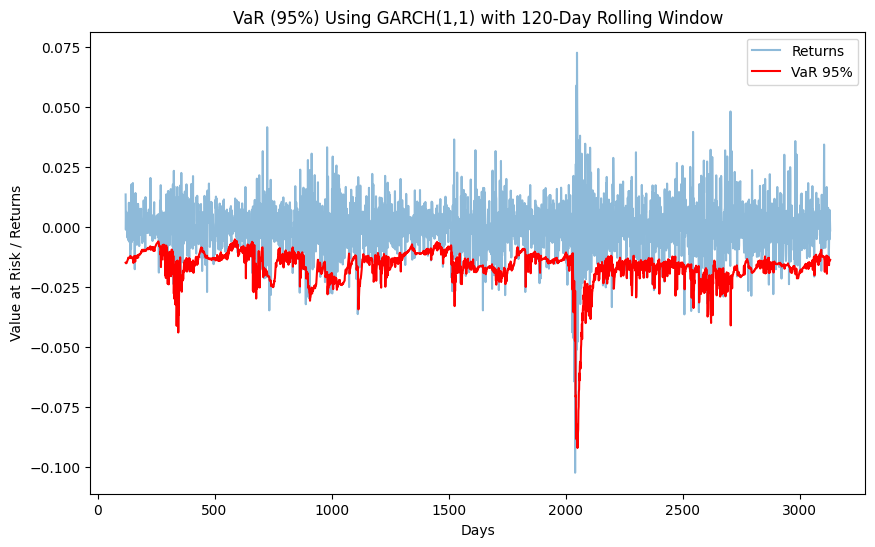

In [5]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
from scipy.stats import norm as norms

# Simulated or historical returns (replace this with actual return data)
#np.random.seed(42)
#n_days = 500 # Simulated 500 days of returns
#returns = np.random.normal(0, 0.01, n_days) # Simulated returns with mean=0 and volatility=1%

# Rolling window length
window = 120
confidence_level = 0.95
alpha=1-confidence_level
#z_score_95 = 1.65 # Approximate z-score for a 95% confidence level
z_score_95= norms.ppf(1 - alpha)

# Lists to store the calculated VaR values
var_95 = []

exceptions_garch = []

# Loop through each window to calculate VaR using GARCH(1,1)
for i in range(window, len(returns)):
    # Extract the rolling window of returns
    windowed_returns = returns[i - window:i]

    # Fit a GARCH(1,1) model to the windowed returns
    model = arch_model(100*windowed_returns, vol='Garch',p=2, q=2, dist='skewt')
    fitted_model = model.fit(disp="off")

    # Forecast the volatility for the next day
    forecast = fitted_model.forecast(horizon=1, start=len(windowed_returns)-1) # Forecast for the next day
    # Check if the forecast is successful
    if forecast.variance.shape[0] > 0:
        forecasted_volatility = np.sqrt(forecast.variance.iloc[-1, 0])

        # Calculate VaR at 95% confidence level
        var_value = z_score_95 * forecasted_volatility/100
        var_95.append(-var_value) # Store negative VaR for comparison with negative returns
        exceptions_garch.append(1 if returns[i] < -var_value else 0)


    else:
        print(f"Warning: GARCH model failed to forecast variance at index {i}")
        var_95.append(np.nan) # Append NaN for failed forecasts

# Plotting the VaR against returns
plt.figure(figsize=(10, 6))
plt.plot(range(window, len(returns)), returns[window:], label="Returns", alpha=0.5)
plt.plot(range(window, len(returns)), var_95, label="VaR 95%", color='red')
plt.title('VaR (95%) Using GARCH(1,1) with 120-Day Rolling Window')
plt.xlabel('Days')
plt.ylabel('Value at Risk / Returns')
plt.legend()
plt.show()

In [13]:
exceptions=exceptions_garch

In [14]:
# Backtesting for each model
models = {
    'GARCH(1,1)': (var_95, exceptions),

}

for model_name, (var_95,  exceptions) in models.items():
    num_exceptions = np.sum( exceptions)
    total_observations = len( exceptions)

    print(f"\nBacktesting for {model_name}:")
    print(f"Number of exceptions: {num_exceptions}")
    print(f"Total observations: {total_observations:.4f}")
    print(f"Failure rate: {num_exceptions / total_observations:.4f}")




Backtesting for GARCH(1,1):
Number of exceptions: 171
Total observations: 3012.0000
Failure rate: 0.0568


In [15]:
# Kupiec Test (Unconditional Coverage)
def kupiec_test(num_exceptions, total_observations, confidence_level):
    p = 1 - confidence_level
    LR_uc = -2 * (num_exceptions * np.log(p) + (total_observations - num_exceptions) * np.log(1 - p) -
                  num_exceptions * np.log(num_exceptions / total_observations) -
                  (total_observations - num_exceptions) * np.log(1 - num_exceptions / total_observations))
    p_value_uc = 1 - chi2.cdf(LR_uc, 1)
    return LR_uc, p_value_uc

LR_uc, p_value_uc = kupiec_test(num_exceptions, total_observations, confidence_level)
print(f"Kupiec's Test - LR_uc: {LR_uc:.4f}, p-value: {p_value_uc:.4f}")


#Interpreting Results
if  p_value_uc < alpha:
    print("Reject the null hypothesis: The VaR model is not accurate.")
else:
    print("Fail to reject the null hypothesis: The VaR model is accurate: the devuation is not statistically significant, the model seems to be performing well.")



Kupiec's Test - LR_uc: 2.7922, p-value: 0.0947
Fail to reject the null hypothesis: The VaR model is accurate: the devuation is not statistically significant, the model seems to be performing well.


**Christofferson**

In [9]:
def christoffersen_test(exceptions):
    T_00 = sum((exceptions[i-1] == 0 and exceptions[i] == 0) for i in range(1, len(exceptions)))
    T_01 = sum((exceptions[i-1] == 0 and exceptions[i] == 1) for i in range(1, len(exceptions)))
    T_10 = sum((exceptions[i-1] == 1 and exceptions[i] == 0) for i in range(1, len(exceptions)))
    T_11 = sum((exceptions[i-1] == 1 and exceptions[i] == 1) for i in range(1, len(exceptions)))

    p_01 = T_01 / (T_00 + T_01)
    p_11 = T_11 / (T_10 + T_11)
    p = (T_01 + T_11) / (T_00 + T_01 + T_10 + T_11)

    LR_cc = -2 * (T_00 * np.log(1 - p) + T_01 * np.log(p) + T_10 * np.log(1 - p) + T_11 * np.log(p) -
                  (T_00 * np.log(1 - p_01) + T_01 * np.log(p_01) + T_10 * np.log(1 - p_11) + T_11 * np.log(p_11)))

    p_value_cc = 1 - chi2.cdf(LR_cc, 1)
    return LR_cc, p_value_cc


In [16]:
    # Christoffersen's Test
    LR_cc, p_value_cc = christoffersen_test(exceptions_garch)
    print(f"Christoffersen's Test - LR_cc: {LR_cc:.4f}, p-value: {p_value_cc:.4f}")



Christoffersen's Test - LR_cc: 3.9117, p-value: 0.0480


**Pearson Q Test**

In [17]:
def pearson_quantile_test(exceptions, confidence_level):
    expected_exceptions = len(exceptions) * (1 - confidence_level)
    chi2_stat = ((np.sum(exceptions) - expected_exceptions) ** 2) / expected_exceptions
    p_value_pq = 1 - chi2.cdf(chi2_stat, 1)
    return chi2_stat, p_value_pq


In [18]:
# Pearson's Quantile Test
chi2_stat, p_value_pq = pearson_quantile_test(exceptions, confidence_level)
print(f"Pearson's Quantile Test - Chi2 Stat: {chi2_stat:.7f}, p-value: {p_value_pq:.7f}")


Pearson's Quantile Test - Chi2 Stat: 2.7633466, p-value: 0.0964463
